# 1. VIS-stats
generate video instance segmentation (VIS) stats for a video datasets


In [1]:
# expose parent directory to import modules
import os
import sys

ROOT_DIR = os.getcwd()
while os.path.basename(ROOT_DIR) != 'DatasetsStatistics':
    ROOT_DIR = os.path.abspath(os.path.join(ROOT_DIR,'..'))
sys.path.insert(0,ROOT_DIR)
os.chdir(ROOT_DIR)

TASK = 'VIS'

In [2]:


# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
import warnings
from collections import defaultdict
sns.set()

from utils import stats_tools
warnings.filterwarnings('ignore')

In [3]:
#

summaries_path = Path('./summaries')
summaries_path= summaries_path / TASK
summaries_path.mkdir(parents=True, exist_ok=True)

In [4]:
# get dataset to file paths
dataset_to_file_paths = stats_tools.get_dataset_to_file_paths(str(summaries_path))

# len(dataset_to_file_paths), dataset_to_file_paths

In [5]:
dataset_to_file_paths

{'skydata': PosixPath('summaries/VIS/skydata/train_SKYVIS_3_alldata_stats.json'),
 'ytvis_2019': PosixPath('summaries/VIS/ytvis_2019/instances_train_sub_stats.json'),
 'ytvis_2021': PosixPath('summaries/VIS/ytvis_2021/instances_train_sub_stats.json')}

In [6]:

global_summary_plain_value_cols_df = pd.DataFrame()
global_summary_videos_stats = pd.DataFrame()
global_areas_ranges_stats = defaultdict(list)
global_tracks_stats = defaultdict(list)

for dataset_name, file_path in dataset_to_file_paths.items():
    
    print("*"*20 + f"{dataset_name}" + "*"*20)
    # load data
    summary = stats_tools.load_summary(file_path=file_path)
    dataset_to_summary = {dataset_name: summary}

    # plain-common-stats-stats-plots-save
    all_columns = list(summary.keys())
    plain_value_cols = {}
    plain_value_cols["dataset_name"] = dataset_name
    plain_value_cols.update({ k:v for (k,v) in summary.items() if not isinstance(summary[k], (list, dict))})
    plain_value_cols.update(summary['info'])
    plain_value_cols.update(summary['_general_stats'])
    plain_value_cols.update(summary['tracks_stats'])
    plain_value_cols.update({
                        'categories_count': summary['_cats']["categories_count"],
                        'super_categories_count': summary['_cats']["super_categories_count"]
                        })
    
    plain_value_cols_df=pd.DataFrame(plain_value_cols, index=[0])
    global_summary_plain_value_cols_df=stats_tools.merge_df(df1=global_summary_plain_value_cols_df, 
                                                            df2=plain_value_cols_df)
    
    #summarize _categories_stats for each dataset
    stats_tools.plot_and_save_per_category_stats(per_category_stats = summary["_categories_stats"],
                                                    dataset_name = dataset_name, 
                                                    save_path = summaries_path)

    ##skydata/coco sizes boxes boxes stats
    # 
    boxes_stats=summary['_areas_stats']
    areas_ranges_stats=boxes_stats['areas_stats']

    global_areas_ranges_stats["dataset_name"].append(dataset_name)
    [global_areas_ranges_stats[k].append(v) for k,v in areas_ranges_stats.items()]
    

    # # summarize tracks
    tracks_stats = summary['tracks_stats']
    global_tracks_stats["dataset_name"].append(dataset_name)
    [global_tracks_stats[k].append(v) for k,v in tracks_stats.items()]


********************skydata********************
[INFO] Loading train_SKYVIS_3_alldata_stats.json
[INFO] Loaded train_SKYVIS_3_alldata_stats.json
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved skydata_per_category_stats.csv
[INFO] Saved.
********************ytvis_2019********************
[INFO] Loading instances_train_sub_stats.json
[INFO] Loaded instances_train_sub_stats.json
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved ytvis_2019_per_category_stats.csv
[INFO] Saved.
********************ytvis_2021********************
[INFO] Loading instances_train_sub_stats.json
[INFO] Loaded instances_train_sub_stats.json
[INFO] saving plot ....
[INFO] saving csv ....
[INFO] Saving plots
[INFO] Saved ytvis_2021_per_category_stats.csv
[INFO] Saved.


In [7]:
# plot generals and save stats

## global_summary_plain_value_cols_df save to csv
stats_tools.save_df_to_csv(df=global_summary_plain_value_cols_df,
                            save_path=summaries_path/'all_datasets',
                            file_name='_plain_value_global.csv')

# ## global_areas_ranges_stats save to csv
stats_tools.summarize_global_areas_ranges_stats_plot_and_save(global_areas_ranges_stats_df=global_areas_ranges_stats,
                                                    save_path=summaries_path/'all_datasets',
                                                    file_name='_areas_ranges_stats_global')


# ## global_tracks_stats save to csv
stats_tools.summarize_global_tracks_stats_plot_and_save(global_tracks_stats_df=global_tracks_stats,
                                                    save_path=summaries_path/'all_datasets',
                                                    file_name='_tracks_stats_global')

[INFO] Saving all_datasets
[INFO] Saved _plain_value_global.csv
[INFO] Global areas stats ....
[INFO] Saving all_datasets
[INFO] Saved _areas_ranges_stats_global.csv
[INFO] Global tracks stats ....
[INFO] Saving all_datasets
[INFO] Saved _tracks_stats_global.csv


In [8]:
### EXTRA PLOTS

# global_summary_plain_value_cols_df.columns

"""
'dataset_name', 
'description', 
'task', 
'videos_count',
'min_resolution', 
'max_resolution', 
'min_height', 
'max_height',
'min_width', 
'max_width', 
'shortest_video', 
'longest_video',
'average_video_length', 
'total_tracks', 
'average_track_length',
'min_track_length', 
'max_track_length', 
'average_tracks_per_video',
'categories_count', 
'super_categories_count'
"""

"\n'dataset_name', \n'description', \n'task', \n'videos_count',\n'min_resolution', \n'max_resolution', \n'min_height', \n'max_height',\n'min_width', \n'max_width', \n'shortest_video', \n'longest_video',\n'average_video_length', \n'total_tracks', \n'average_track_length',\n'min_track_length', \n'max_track_length', \n'average_tracks_per_video',\n'categories_count', \n'super_categories_count'\n"

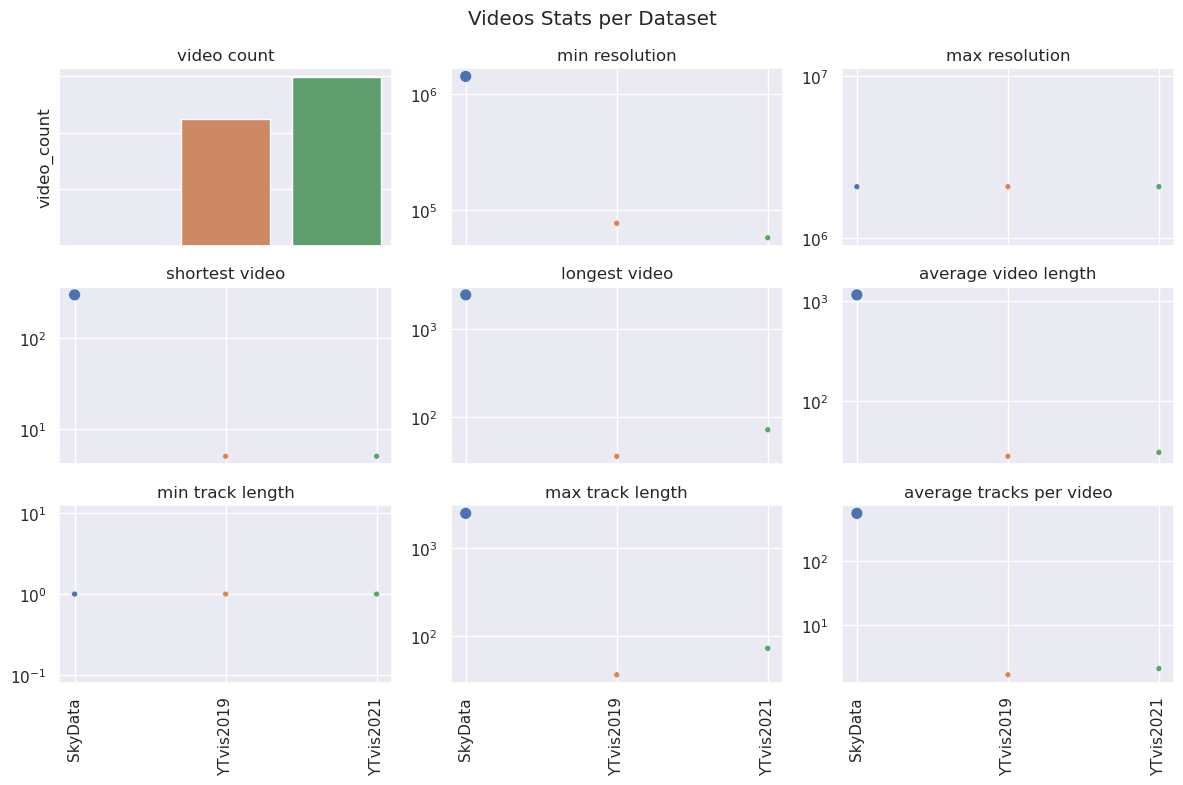

In [9]:
"""
sequence lengths
"""



import seaborn as sns
import matplotlib.pyplot as plt

# df.keys()
# some plots
df = global_summary_plain_value_cols_df

# plot distributions

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle('Videos Stats per Dataset')
plt.yscale('log')
interested_in =[ 'video_count', 
                'min_resolution', 
                'max_resolution', 
                'shortest_video', 
                'longest_video', 
                'average_video_length', 
                'min_track_length',
                'max_track_length',
                'average_tracks_per_video', 
                'categories_count',
                'super_categories_count']

rows = 3
cols = 3
for i in range(rows):
    for j in range(cols):    
        interested_idx = i*rows + j
        interested = interested_in[interested_idx]
        
        if interested == 'video_count':
            with sns.axes_style("ticks"):
                sns.barplot(data=df, x='dataset_name', y=f'{interested}', ax=axes[i, j])
                axes[i, j].set_title(f'{str(interested.replace("_"," "))}')
                axes[i, j].set_xlabel('')
                axes[i, j].set_ylabel(f'{interested}')
                axes[i, j].tick_params(axis='x', rotation=90 , labelbottom=False)
                axes[i, j].tick_params(axis='y', labelleft=False)
        
        else:            
            with sns.axes_style("ticks"):
                axes[i, j].set(yscale="log")
                sns.scatterplot(data=df, x='dataset_name', 
                                y=f'{interested}', 
                                ax=axes[i, j], 
                                hue="dataset_name",
                                size=interested,
                                legend=False
                                )
                axes[i, j].set_title(f'{str(interested.replace("_"," "))}')
                axes[i, j].set_xlabel('')
                axes[i, j].set_ylabel('')
                axes[i, j].tick_params(axis='x', rotation=90, labelbottom=False)
                axes[i, j].tick_params(axis='y', labelleft=True)
            
            


# show ticks for the last row
for j in range(cols):
    axes[rows-1, j].tick_params(axis='x', rotation=90, labelbottom=True)

# Adjust spacing
plt.tight_layout()
# Show the plots
# plt.show()


file_name = f'{TASK}_general_stats'
save_path = Path("summaries/showcase")
save_path.mkdir(parents=True, exist_ok=True)
plt.savefig(str(save_path/f'{file_name}.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
